In [3]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from statistics import mean
import xgboost as xgb



In [5]:
df = pd.read_csv('train.csv')

In [6]:
df_copy = df.copy()

In [ ]:
df_copy.head(8)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7


In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [ ]:
nan_counts = df_copy.isna().sum()
print(nan_counts)

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
row_id                           0
wap_is_null                      0
near_price_is_null               0
far_price_is_null                0
volume                           0
mid_price                      132
liquidity_imbalance              0
matched_imbalance              132
size_imbalance                   0
volume_diff                      0
imbalance_ratio                132
median_size                      0
std_size            

drop the data with target missing

In [7]:
df_copy.dropna(subset=['target'], inplace=True)

In [ ]:
nan_counts = df_copy.isna().sum()
print(nan_counts)

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
row_id                           0
dtype: int64


In [ ]:
def check_nan_attribute(attribute, columns_to_exclude):
  # Initialize an empty DataFrame to store NaN counts for each day and column
  nan_counts = pd.DataFrame(columns=df_copy.columns.difference(columns_to_exclude))

  for i in range(df_copy[attribute].max() + 1):
    attribute_df = df_copy[df_copy[attribute] == i]
    na_count = attribute_df.drop(columns=columns_to_exclude).isna().sum()
    nan_counts = nan_counts.append(na_count, ignore_index=True)
  plt.figure(figsize=(20, 6))
  for column in nan_counts.columns:
      plt.plot(range(df_copy[attribute].max() + 1), nan_counts[column], marker='o', linestyle = 'None', label=column)

  plt.title('Count of NaN Values in Different Columns for Each' + attribute)
  plt.xlabel(attribute)
  plt.ylabel('Count of NaN Values')
  plt.legend()
  plt.show()




<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecat

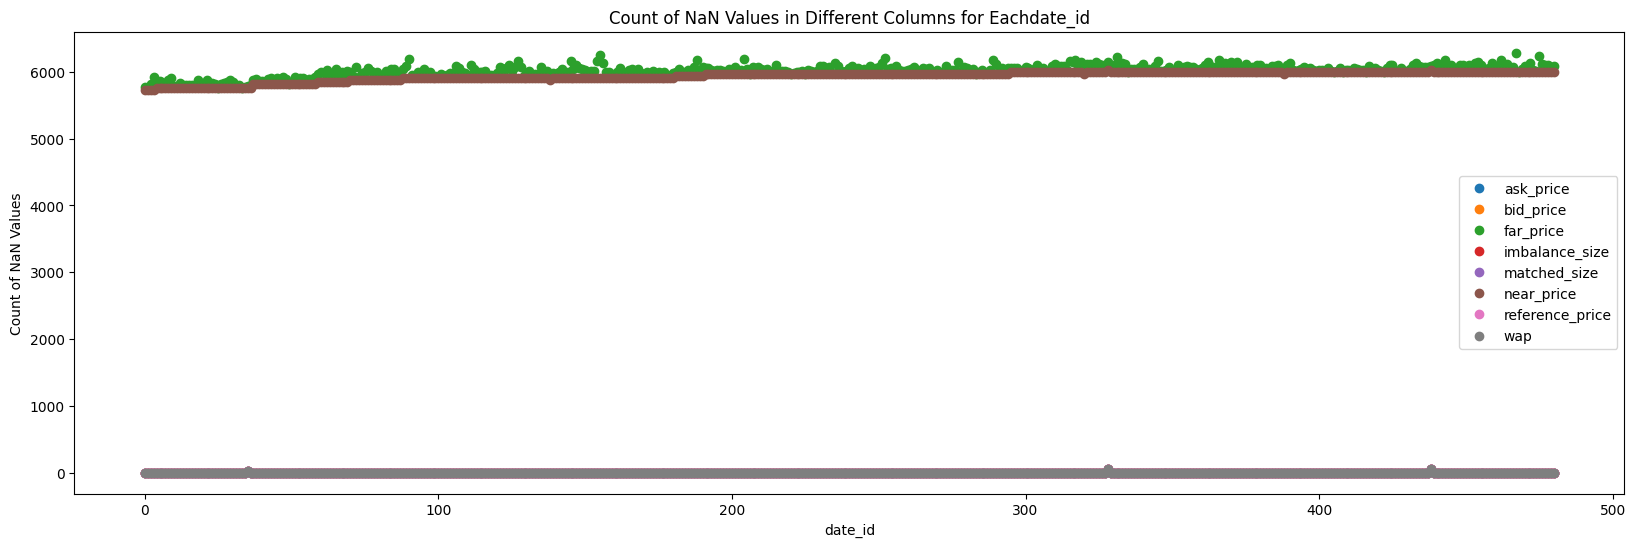

In [ ]:
columns_to_exclude = ['stock_id', 'date_id', 'target', 'seconds_in_bucket', 'imbalance_buy_sell_flag', 'bid_size', 'ask_size', 'time_id', 'row_id']
check_nan_attribute('date_id', columns_to_exclude)


<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecat

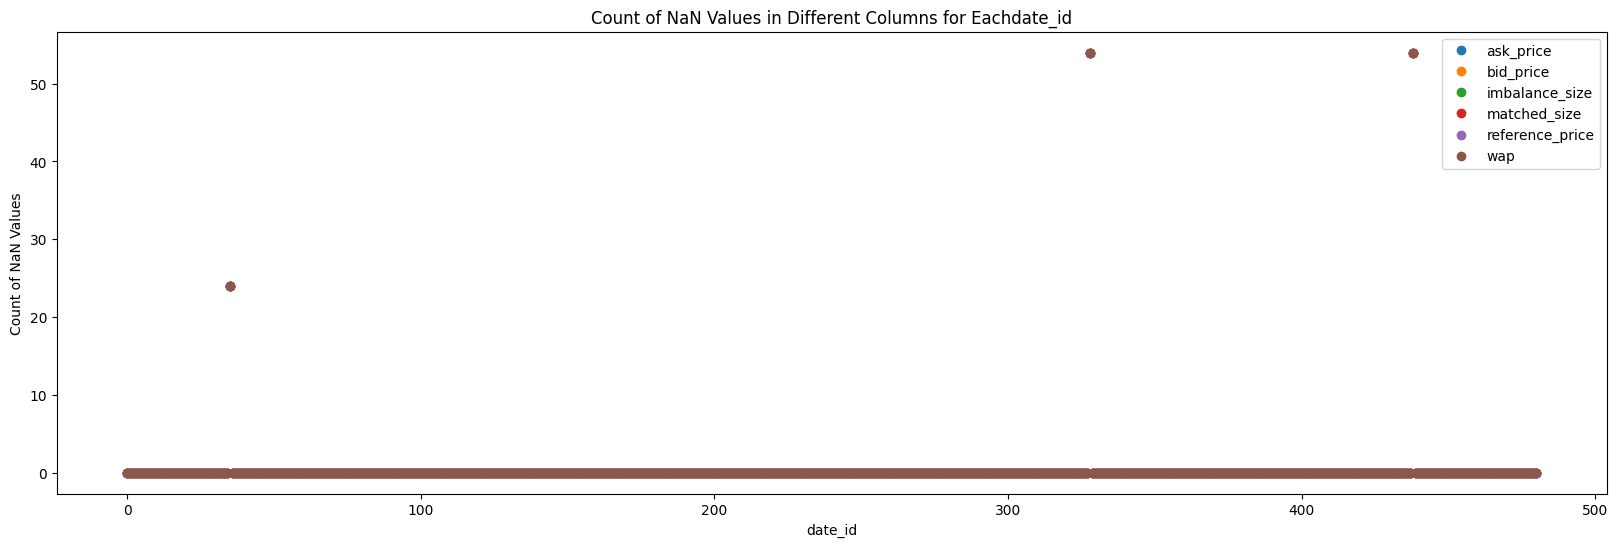

In [ ]:
columns_to_exclude += ['near_price', 'far_price']
check_nan_attribute('date_id', columns_to_exclude)

<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecat

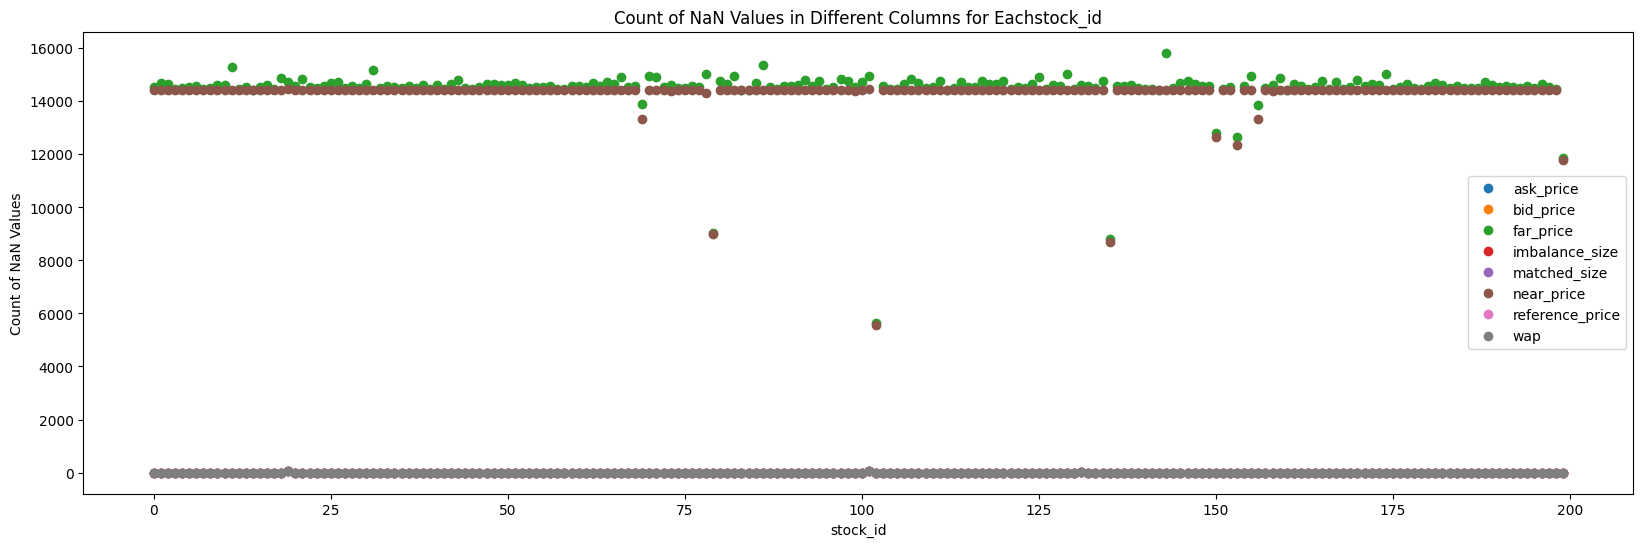

In [ ]:
columns_to_exclude = ['stock_id', 'date_id', 'target', 'seconds_in_bucket', 'imbalance_buy_sell_flag', 'bid_size', 'ask_size', 'time_id', 'row_id']
check_nan_attribute('stock_id', columns_to_exclude)

<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nan_counts = nan_counts.append(na_count, ignore_index=True)
<ipython-input-9-14cf87b72785>:8: FutureWarning: The frame.append method is deprecat

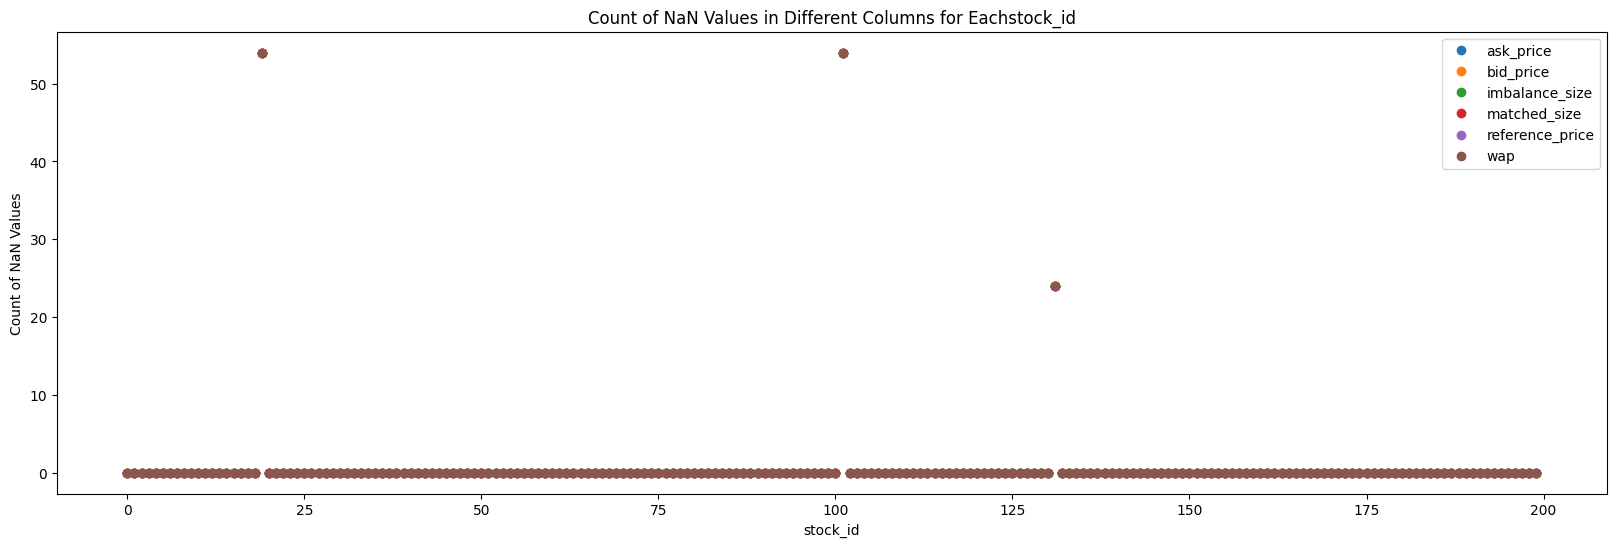

In [ ]:
columns_to_exclude += ['near_price', 'far_price']
check_nan_attribute('stock_id', columns_to_exclude)

There are missing data on specific date and stock.
Let's check if there are some stocks missing data on some days entirely.

In [ ]:
# Assuming df_copy is your DataFrame
selected_columns = ['wap', 'reference_price', 'bid_price', 'ask_price', 'matched_size', 'imbalance_size']

nan_rows = df_copy[df_copy[selected_columns].isnull().any(axis=1)]
print("stocks has missing values: " + str(nan_rows['stock_id'].unique()))

stock131 = nan_rows[nan_rows['stock_id'] == 131]
print("stock 131 has missing " + str(stock131['date_id'].count()) + " data on date " + str(stock131['date_id'].unique())+ " in time frame from " + str(stock131['time_id'].iloc[0]) + " to " + str(stock131['time_id'].iloc[-1]))
stock19 = nan_rows[nan_rows['stock_id'] == 19]
print("stock 19 has missing " + str(stock19['date_id'].count()) + " data on date " + str(stock19['date_id'].unique())+ " in time frame from " + str(stock19['time_id'].iloc[0]) + " to " + str(stock19['time_id'].iloc[-1]))
stock101 = nan_rows[nan_rows['stock_id'] == 101]
print("stock 101 has missing " + str(stock101['date_id'].count()) + " data on date " + str(stock101['date_id'].unique()) + " in time frame from " + str(stock101['time_id'].iloc[0]) + " to " + str(stock101['time_id'].iloc[-1]))


stocks has missing values: [131 101  19]
stock 131 has missing 24 data on date [35] in time frame from 1955 to 1978
stock 19 has missing 54 data on date [438] in time frame from 24091 to 24144
stock 101 has missing 54 data on date [328] in time frame from 18041 to 18094


Check correlation between features for making guesses in missing values

<ipython-input-15-04ca8a572d85>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_copy.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')


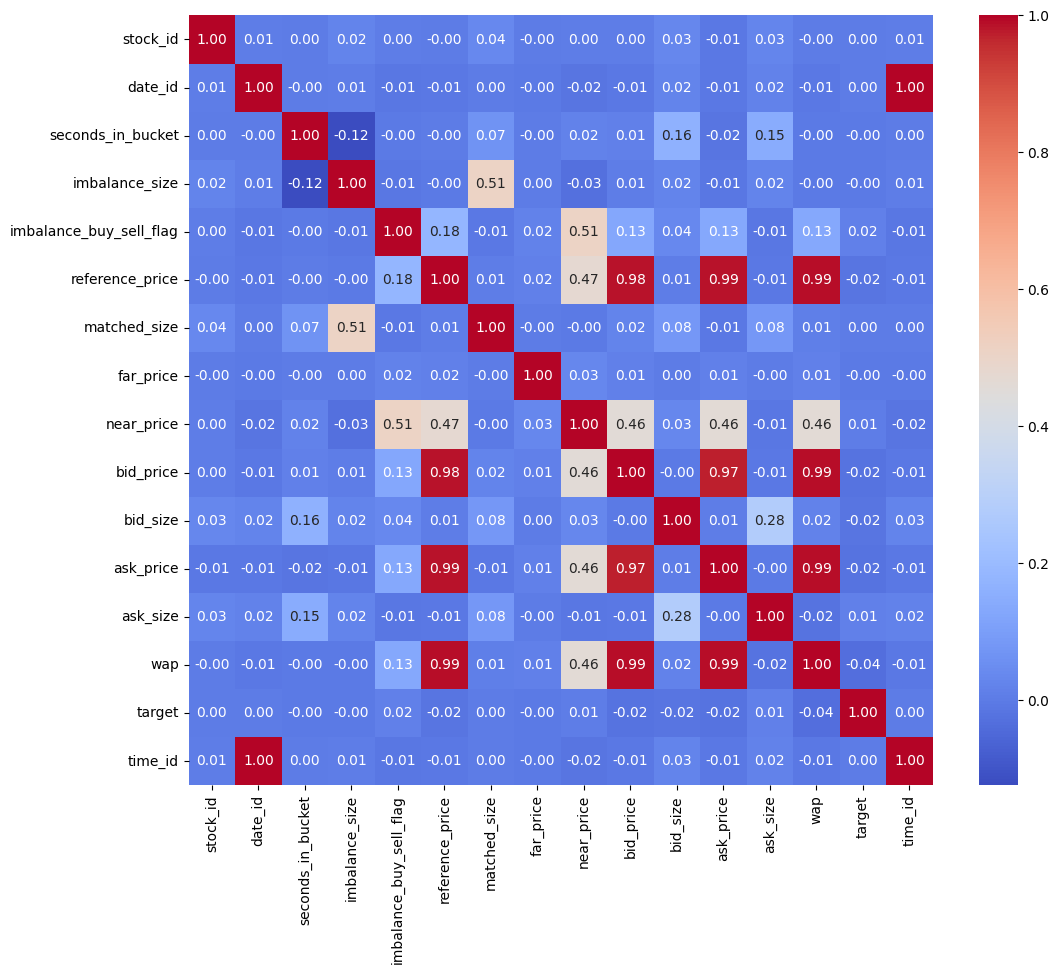

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_copy.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.show()

Since the atrributes that has high correlation are the missing ones, i cannot use for filling the values.

In [8]:
df_copy['wap_is_null'] = df_copy['wap'].isnull()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


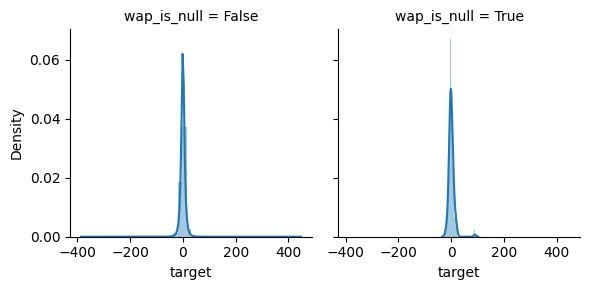

In [ ]:
g = sns.FacetGrid(df_copy, col='wap_is_null')
g = g.map(sns.distplot, "target")

In [9]:
df_copy['near_price_is_null'] = df_copy['near_price'].isnull()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


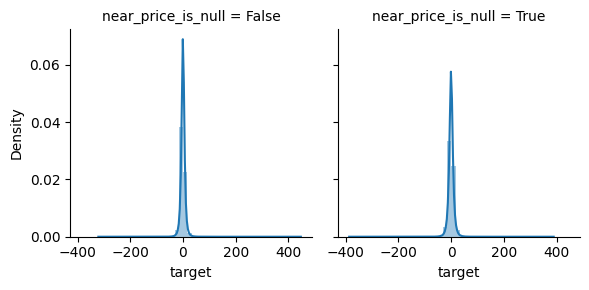

In [ ]:
g = sns.FacetGrid(df_copy, col='near_price_is_null')
g = g.map(sns.distplot, "target")

In [10]:
df_copy['far_price_is_null'] = df_copy['far_price'].isnull()

Text(0.5, 1.0, 'far price')

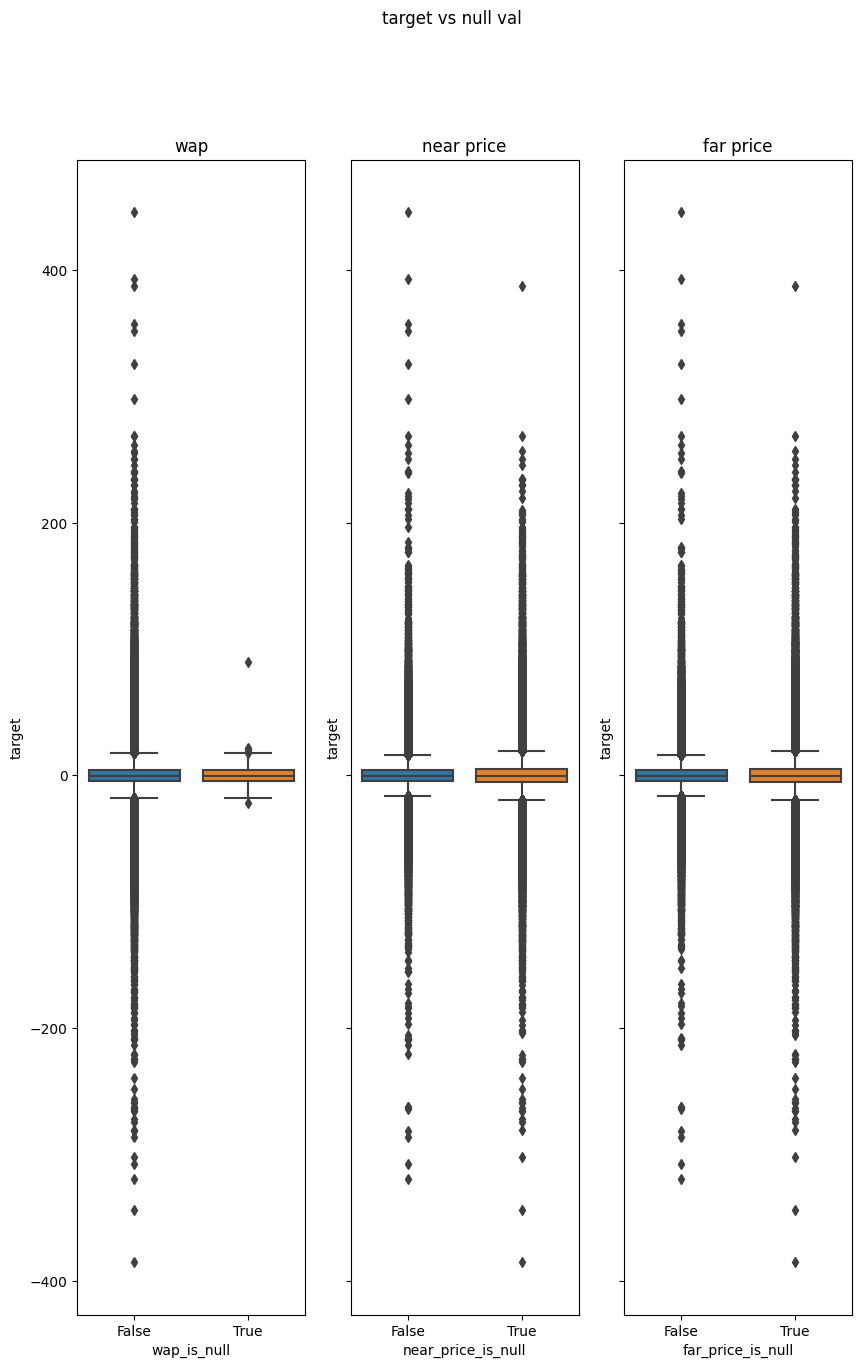

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 15), sharey=True)
fig.suptitle('target vs null val')
sns.boxplot(ax=axes[0], x='wap_is_null', y='target', data=df_copy)
axes[0].set_title("wap")
sns.boxplot(ax=axes[1], x='near_price_is_null', y='target', data=df_copy)
axes[1].set_title("near price")
sns.boxplot(ax=axes[2], x='far_price_is_null', y='target', data=df_copy)
axes[2].set_title("far price")

Add some more features

In [11]:
df_copy["volume"] = df_copy.eval("ask_size + bid_size")
df_copy["volume_diff"] = df_copy.eval("ask_size - bid_size")
df_copy['imbalance_ratio'] = df_copy.eval('imbalance_size / matched_size')
df_copy["mid_price"] = df_copy.eval("(ask_price + bid_price) / 2")
df_copy["liquidity_imbalance"] = df_copy.eval("(bid_size-ask_size)/(bid_size+ask_size)")
df_copy["matched_imbalance"] = df_copy.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
df_copy["size_imbalance"] = df_copy.eval("bid_size / ask_size")


In [12]:
median_sizes = df_copy.groupby('stock_id')['bid_size'].median() + df_copy.groupby('stock_id')['ask_size'].median()
std_sizes = df_copy.groupby('stock_id')['bid_size'].std() + df_copy.groupby('stock_id')['ask_size'].std()
max_sizes = df_copy.groupby('stock_id')['bid_size'].max() + df_copy.groupby('stock_id')['ask_size'].max()
min_sizes = df_copy.groupby('stock_id')['bid_size'].min() + df_copy.groupby('stock_id')['ask_size'].min()
mean_sizes = df_copy.groupby('stock_id')['bid_size'].mean() + df_copy.groupby('stock_id')['ask_size'].mean()
first_sizes = df_copy.groupby('stock_id')['bid_size'].first() + df_copy.groupby('stock_id')['ask_size'].first()
last_sizes = df_copy.groupby('stock_id')['bid_size'].last() + df_copy.groupby('stock_id')['ask_size'].last()
df_copy['median_size'] = df_copy['stock_id'].map(median_sizes.to_dict())
df_copy['std_size'] = df_copy['stock_id'].map(std_sizes.to_dict())
df_copy['max_size'] = df_copy['stock_id'].map(max_sizes.to_dict())
df_copy['min_size'] = df_copy['stock_id'].map(min_sizes.to_dict())
df_copy['mean_size'] = df_copy['stock_id'].map(mean_sizes.to_dict())
df_copy['first_size'] = df_copy['stock_id'].map(first_sizes.to_dict())
df_copy['last_size'] = df_copy['stock_id'].map(last_sizes.to_dict())

df_copy['high_volume'] = np.where(df_copy['volume'] > df_copy['median_size'], 1, 0)

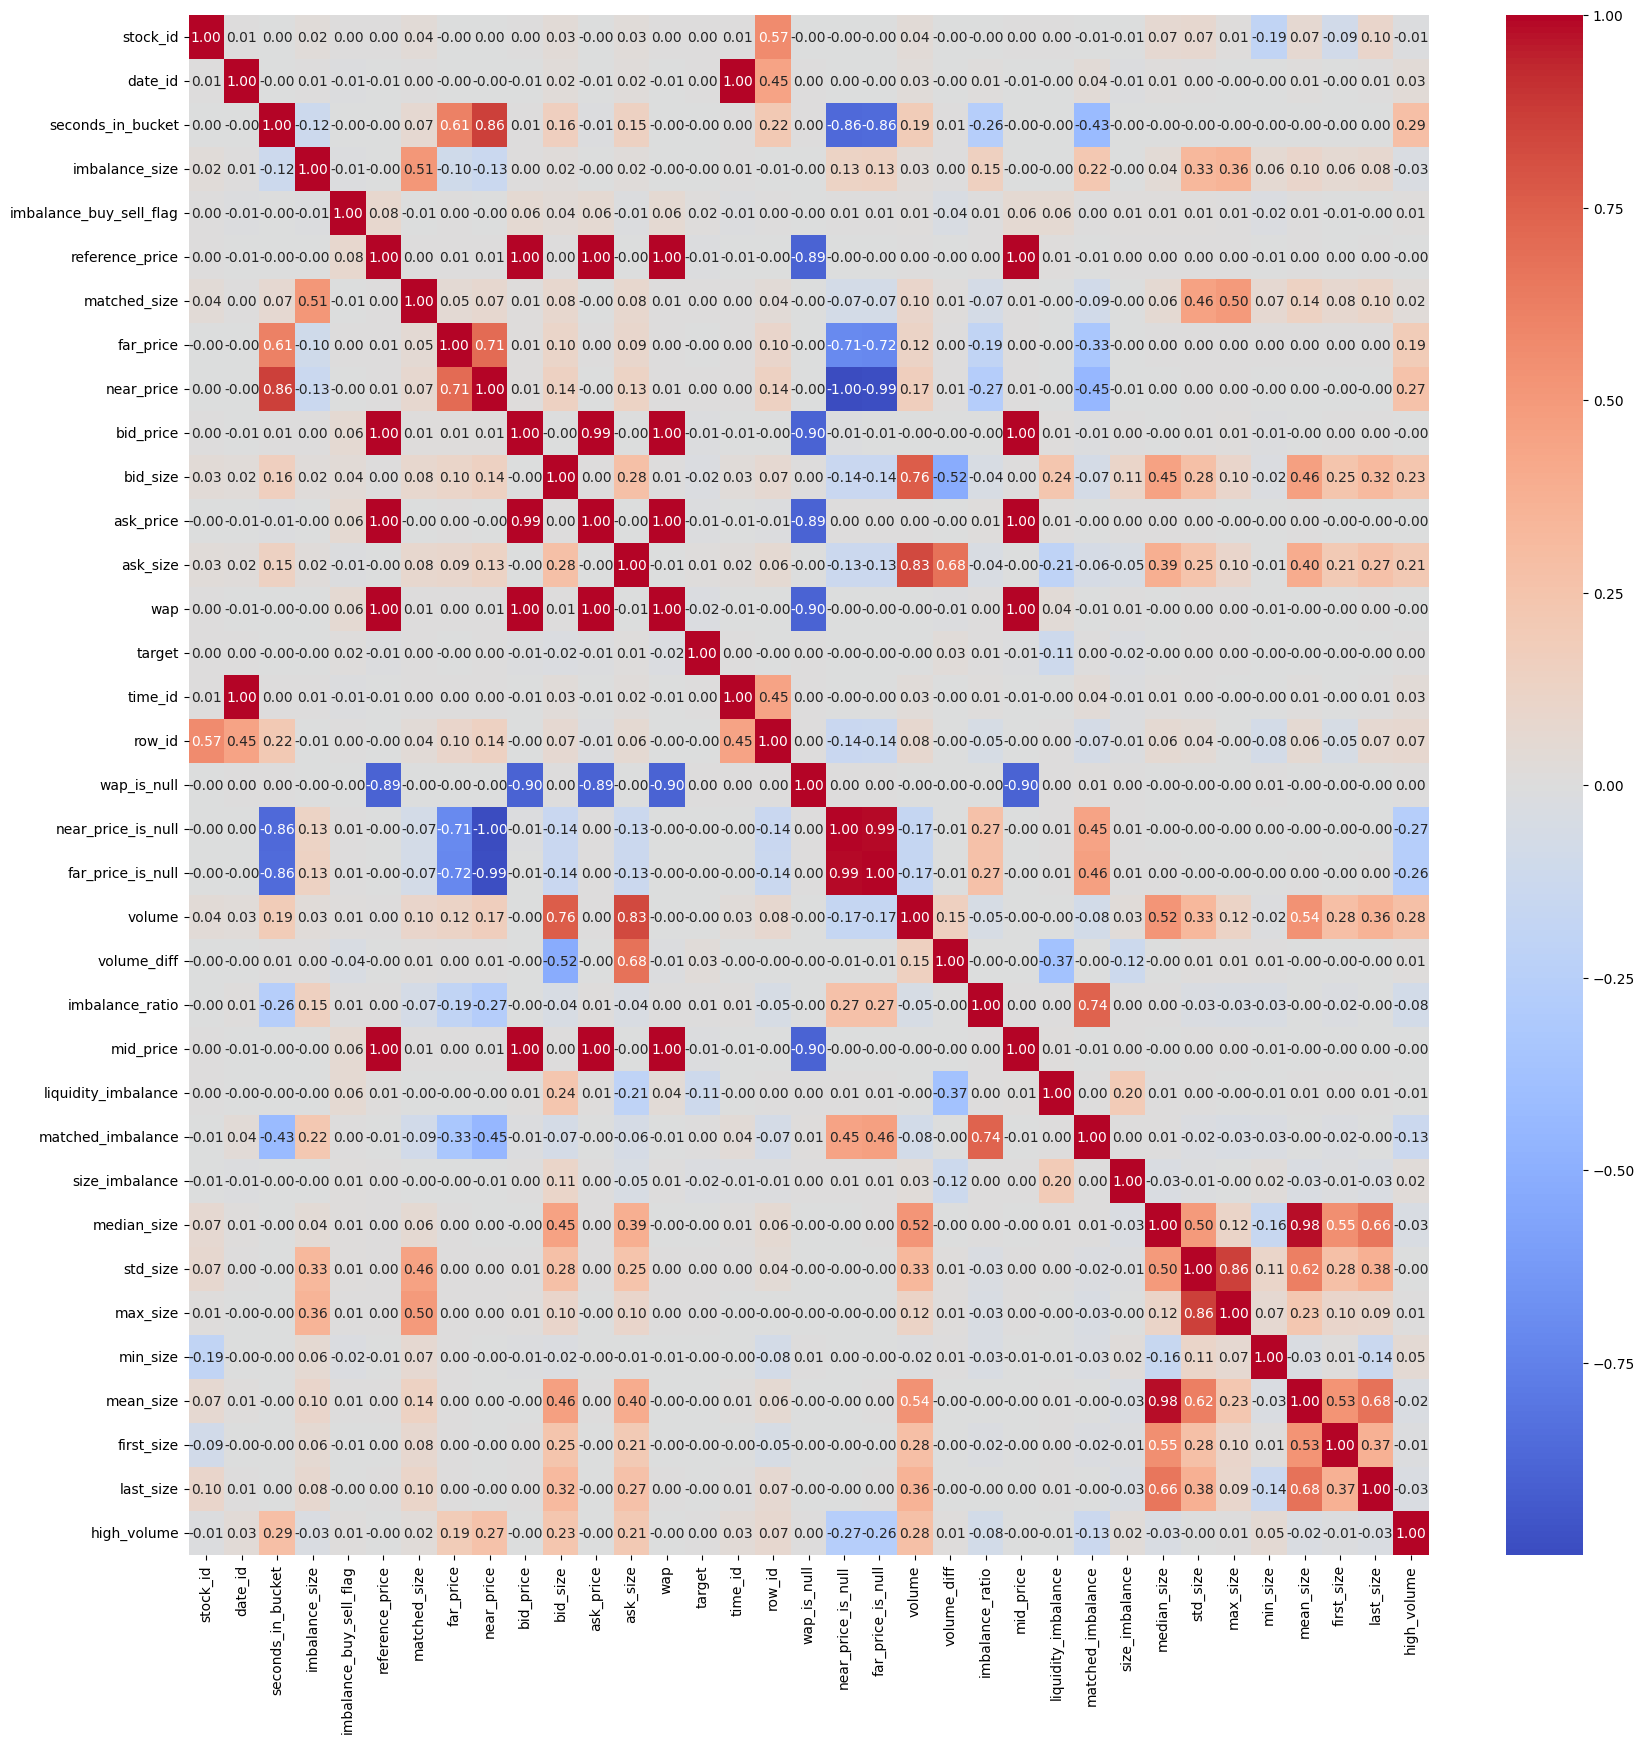

In [13]:
df_copy.fillna(0, inplace = True)
plt.figure(figsize=(20, 20))
sns.heatmap(df_copy.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.show()

In [14]:
df_copy.drop(columns=['row_id'], inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237892 entries, 0 to 5237979
Data columns (total 34 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  wap_is_null              bool   
 17  near_price_is_null       bool   
 18  far_price_is_null        bool   
 19  volume                   float64
 20  volume_diff              float64
 21  imbalance_rat

Make Time Series

In [15]:
df_copy['date_seconds_in_bucket'] = df_copy['date_id'] + df_copy['seconds_in_bucket']
df_copy['date_seconds_in_bucket'] = pd.to_datetime(df_copy['date_seconds_in_bucket'])
df_copy.set_index('date_seconds_in_bucket', inplace=True)
df_copy = df_copy.sort_index()
df_copy.replace([np.inf, -np.inf], 0, inplace = True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5237892 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000001020
Data columns (total 34 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  wap_is_null              bool   
 17  near_price_is_null       bool   
 18  far_price_is_null        bool   
 19  volume                   float64
 20  vol

In [16]:
df_copy.drop(columns=['date_id', 'seconds_in_bucket', 'time_id'], inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5237892 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000001020
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   imbalance_size           float64
 2   imbalance_buy_sell_flag  int64  
 3   reference_price          float64
 4   matched_size             float64
 5   far_price                float64
 6   near_price               float64
 7   bid_price                float64
 8   bid_size                 float64
 9   ask_price                float64
 10  ask_size                 float64
 11  wap                      float64
 12  target                   float64
 13  wap_is_null              bool   
 14  near_price_is_null       bool   
 15  far_price_is_null        bool   
 16  volume                   float64
 17  volume_diff              float64
 18  imbalance_ratio          float64
 19  mid_price                float64
 20  liq

Start Training XGB Regression

In [17]:

X = df_copy.drop(columns=['target'])
y = df_copy['target']

errors = []
tscv = TimeSeriesSplit(n_splits=5)

for max_depth in [6, 7, 8, 9, 10]:
    for n_estimators in [50, 75, 100]:
        for eta in [0.01, 0.05, 0.1]:
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=eta,
                random_state=123
            )

            for train_index, valid_index in tscv.split(X):
                X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
                y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

                model.fit(X_train, y_train)

                # Make predictions on the validation set
                predictions = model.predict(X_valid)

                # Calculate the mean absolute error
                mae = mean_absolute_error(y_valid, predictions)

                # Store the max_depth and error in the errors list
                errors.append((max_depth, n_estimators, eta, mae))

# Convert errors list to a DataFrame
errors_df = pd.DataFrame(errors, columns=['max_depth', 'n_estimators', 'eta', 'mae'])

print(errors_df)

     max_depth  n_estimators   eta       mae
0            6            50  0.01  6.878494
1            6            50  0.01  6.453481
2            6            50  0.01  6.427732
3            6            50  0.01  6.593553
4            6            50  0.01  5.435219
..         ...           ...   ...       ...
220         10           100  0.10  6.884918
221         10           100  0.10  6.446040
222         10           100  0.10  6.413967
223         10           100  0.10  6.581546
224         10           100  0.10  5.441118

[225 rows x 4 columns]


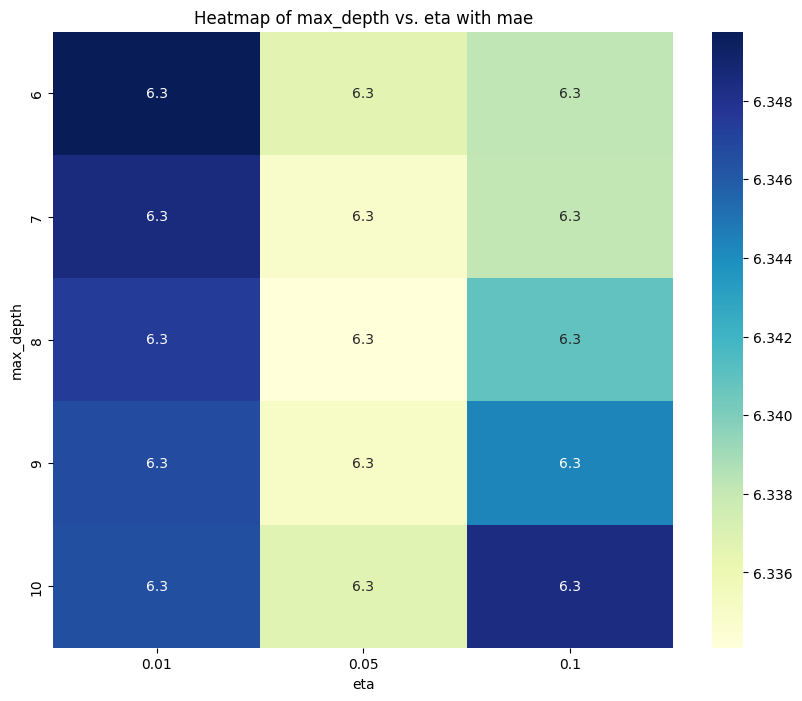

In [32]:
pivot_table = errors_df.pivot_table(values="mae", index="max_depth", columns="eta")

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.xlabel("eta")
plt.ylabel("max_depth")
plt.title("Heatmap of max_depth vs. eta with mae")
plt.show()

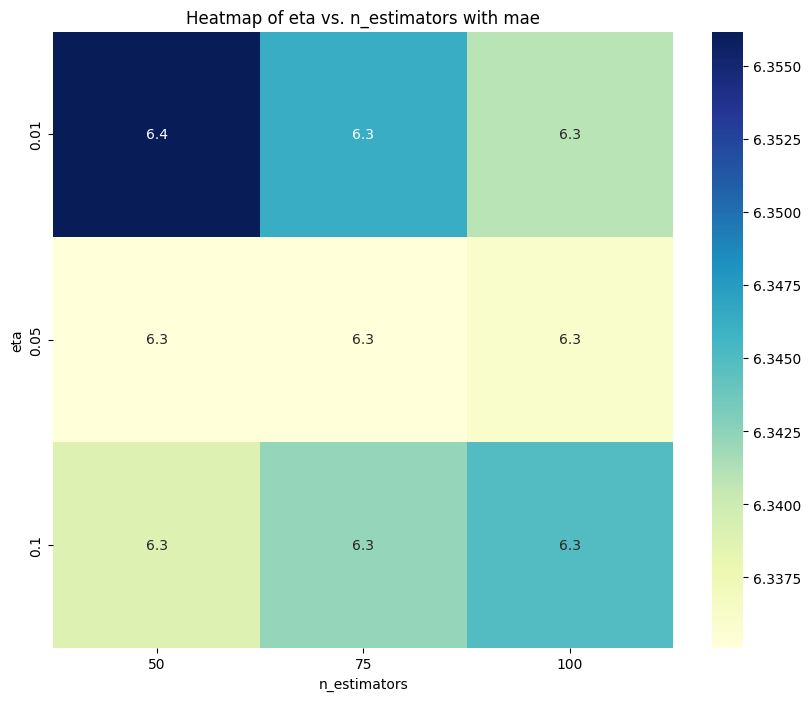

In [31]:
pivot_table = errors_df.pivot_table(values="mae", index="eta", columns="n_estimators")

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.xlabel("n_estimators")
plt.ylabel("eta")
plt.title("Heatmap of eta vs. n_estimators with mae")
plt.show()

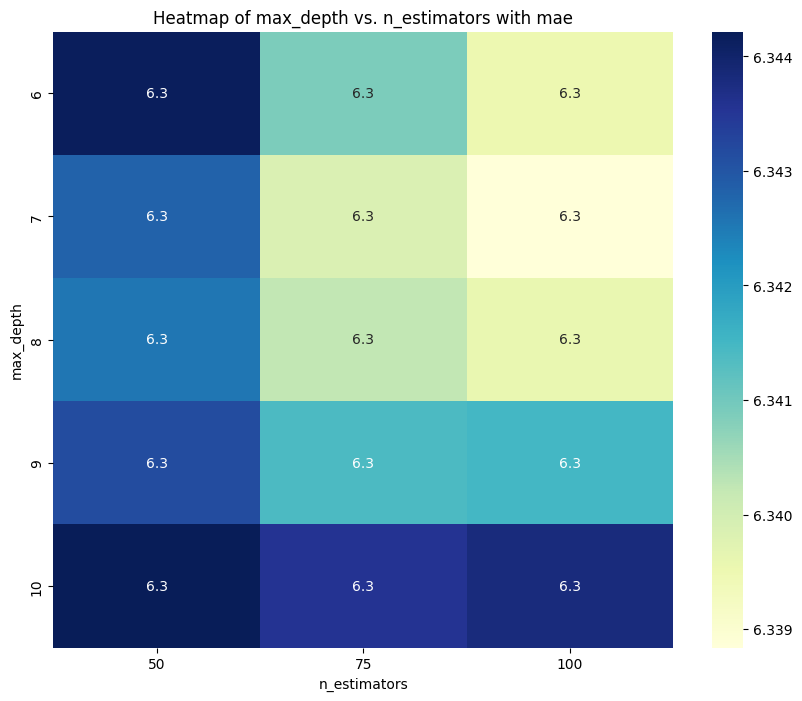

In [24]:
pivot_table = errors_df.pivot_table(values="mae", index="max_depth", columns="n_estimators")

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("Heatmap of max_depth vs. n_estimators with mae")
plt.show()


In [21]:
print(errors_df[errors_df["mae"]==5.426743005345146])

     max_depth  n_estimators   eta       mae
144          9            50  0.05  5.426743


In [35]:
errors = []
tscv = TimeSeriesSplit(n_splits=5)

for max_depth in [7, 8, 9, 10]:
    for n_estimators in [50, 75, 100]:
        for eta in [0.05, 0.06, 0.07, 0.08]:
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=eta,
                random_state=123
            )

            for train_index, valid_index in tscv.split(X):
                X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
                y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

                model.fit(X_train, y_train)

                # Make predictions on the validation set
                predictions = model.predict(X_valid)

                # Calculate the mean absolute error
                mae = mean_absolute_error(y_valid, predictions)

                # Store the max_depth and error in the errors list
                errors.append((max_depth, n_estimators, eta, mae))

# Convert errors list to a DataFrame
errors_df = pd.DataFrame(errors, columns=['max_depth', 'n_estimators', 'eta', 'mae'])

print(errors_df)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x4dd55d750>>
Traceback (most recent call last):
  File "/Users/liam/Desktop/TessDM/my_venv/lib/python3.11/site-packages/xgboost/core.py", line 588, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


XGBoostError: [00:10:34] /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:231: Check failed: accumulated_rows == Info().num_row_ (3491928 vs. 6983856) : 
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000293cf0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000293de2330 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 6568
  [bt] (2) 3   libxgboost.dylib                    0x0000000293de0330 xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1072
  [bt] (3) 4   libxgboost.dylib                    0x0000000293d9e3e4 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 140
  [bt] (4) 5   libxgboost.dylib                    0x0000000293cfa4b0 XGQuantileDMatrixCreateFromCallback + 516
  [bt] (5) 6   libffi.dylib                        0x00000001ae427050 ffi_call_SYSV + 80
  [bt] (6) 7   libffi.dylib                        0x00000001ae42faf8 ffi_call_int + 1208
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000102eac87c _ctypes_callproc + 796
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000102ea747c PyCFuncPtr_call + 220



In [ ]:
print(min(errors_df["mae"]))

5.4260503624836565


In [36]:
print(errors_df[errors_df["mae"]==5.4260503624836565])

     max_depth  n_estimators   eta      mae
129          9            50  0.06  5.42605
